In [88]:
import os
import json
import re

# Get current working directory (notebook location)
base_dir = os.getcwd()

# Path to the "results" folder
results_dir = os.path.join(base_dir, 'result')

# Path to the figure output dir
figures_dir = os.path.join(base_dir, 'figure')

# Regex pattern to match folders like "20250425_080607"
date_pattern = re.compile(r'^\d{8}_\d{6}$')

# List to store all parsed JSON data
all_data = []

# Iterate through all subdirectories in "results"
for folder_name in os.listdir(results_dir):
    folder_path = os.path.join(results_dir, folder_name)
    
    if os.path.isdir(folder_path) and date_pattern.match(folder_name):
        print(f"Reading folder: {folder_path}")
        
        # Iterate through all JSON files in the folder
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.json'):
                file_path = os.path.join(folder_path, file_name)
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        data = json.load(f)
                        print(f"Loaded file: {file_path}")
                        all_data.append(data)
                except Exception as e:
                    print(f"Error reading file {file_path}: {e}")

Reading folder: G:\ustc\m大模型推理优化加速\paper\dxz\evaluation\slo_attainment\result\20250427_122750
Loaded file: G:\ustc\m大模型推理优化加速\paper\dxz\evaluation\slo_attainment\result\20250427_122750\vllm-v0_--textcaps=0_--pope=0_--mme=0_--text_vqa=0_--vizwiz_vqa=1_results.json
Loaded file: G:\ustc\m大模型推理优化加速\paper\dxz\evaluation\slo_attainment\result\20250427_122750\vllm-v0_--textcaps=0_--pope=0_--mme=0_--text_vqa=1_--vizwiz_vqa=0_results.json
Loaded file: G:\ustc\m大模型推理优化加速\paper\dxz\evaluation\slo_attainment\result\20250427_122750\vllm-v0_--textcaps=0_--pope=0_--mme=1_--text_vqa=0_--vizwiz_vqa=0_results.json
Loaded file: G:\ustc\m大模型推理优化加速\paper\dxz\evaluation\slo_attainment\result\20250427_122750\vllm-v0_--textcaps=0_--pope=1_--mme=0_--text_vqa=0_--vizwiz_vqa=0_results.json
Loaded file: G:\ustc\m大模型推理优化加速\paper\dxz\evaluation\slo_attainment\result\20250427_122750\vllm-v0_--textcaps=1_--pope=0_--mme=0_--text_vqa=0_--vizwiz_vqa=0_results.json
Loaded file: G:\ustc\m大模型推理优化加速\paper\dxz\evaluation\slo

In [89]:
model_dataset_to_logs = {} # model: str, dataset: str -> list[log]
models = set()
datasets = set()
methods = set()

for data in all_data:
    model = data['model']
    dataset: str = ""
    if sum(1 for v in data['datasets'].values() if v != 0) > 1:
        dataset = 'mixed'
    else:
        dataset = next(k for k, v in data['datasets'].items() if v != 0)
        
    models.add(model)
    datasets.add(dataset)
    methods.add(data['method_name'])
        
    if (model, dataset) not in model_dataset_to_logs:
        model_dataset_to_logs[model, dataset] = []
    model_dataset_to_logs[model, dataset].append(data)

In [90]:
n_models = len(models)
n_datasets = len(datasets)
n_methods = len(methods)

print(f'models: {models}')
print(f'datasets {datasets}')
print(f'methods {methods}')

print(f'number of models {n_models}')
print(f'number of datasets {n_datasets}')
print(f'number of methods {methods}')

for (model, dataset), methods_data in model_dataset_to_logs.items():
    print(f'number of methods {len(methods_data)}', model, dataset)

models: {'llava-hf/llava-v1.6-vicuna-7b-hf'}
datasets {'textcaps', 'vizwiz_vqa', 'text_vqa', 'pope', 'mme'}
methods {'ours-ms', 'ours', 'vllm-v0', 'vllm6', 'vllm7', 'vllm'}
number of models 1
number of datasets 5
number of methods {'ours-ms', 'ours', 'vllm-v0', 'vllm6', 'vllm7', 'vllm'}
number of methods 6 llava-hf/llava-v1.6-vicuna-7b-hf vizwiz_vqa
number of methods 6 llava-hf/llava-v1.6-vicuna-7b-hf text_vqa
number of methods 6 llava-hf/llava-v1.6-vicuna-7b-hf mme
number of methods 6 llava-hf/llava-v1.6-vicuna-7b-hf pope
number of methods 6 llava-hf/llava-v1.6-vicuna-7b-hf textcaps


In [91]:
import numpy as np
from dataclasses import dataclass
# caculate all slo settings to select best TTFT SLOs and TPOT SLOs
TTFT_SLOs = [1, 2, 4, 8, 10, 12, 15, 16]
TPOT_SLOs = [0.06, 0.08, 0.10, 0.12, 0.14, 0.15, 0.16]

@dataclass
class LineData:
    model: str
    dataset: str
    ttft_slo: float
    tpot_slo: float
    method: str
    request_rates: list[float]
    n_output_tokens: list[int]
    avg_latency: list[float]
    p90_latency: list[float]
    p99_latency: list[float]
    avg_ttft: list[float]
    p90_ttft: list[float]
    p99_ttft: list[float]
    avg_tpot: list[float]
    p90_tpot: list[float]
    p99_tpot: list[float]
    ttft_slo_attainment: list[float]
    tpot_slo_attainment: list[float]
    slo_attainment: list[float]
    
all_line_data: list[LineData] = []
selected_line_data: list[LineData] = []

for (model, dataset), methods_data in model_dataset_to_logs.items():
    candidate_line_data: dict[tuple[float, float], list[LineData]] = {(ttft, tpot) : [] for ttft in TTFT_SLOs for tpot in TPOT_SLOs}
    for TTFT_SLO in TTFT_SLOs:
        for TPOT_SLO in TPOT_SLOs:
            for method_data in methods_data:
                request_rates: list[float] = []
                n_output_tokens: list[int] = []
                avg_latency: list[float] = [] 
                p90_latency: list[float] = [] 
                p99_latency: list[float] = [] 
                avg_ttft: list[float] = [] 
                p90_ttft: list[float] = [] 
                p99_ttft: list[float] = [] 
                avg_tpot: list[float] = [] 
                p90_tpot: list[float] = [] 
                p99_tpot: list[float] = [] 
                tpot_slo_attainment: list[float] = []
                ttft_slo_attainment: list[float] = []
                slo_attainment: list[float] = []
                
                method = method_data['method_name']
                results = method_data['results']
                for result in results:
                    all_ttfts: list[float] = []
                    all_tpots: list[float] = []
                    all_latencies: list[float] = []
                    sum_output_tokens: int = 0
                    request_rate = result['request_rate']
                    outputs = result['outputs']
                    total_requests = len(outputs)

                    ttft_satisfied_cnt = 0
                    tpot_satisfied_cnt = 0
                    satisfied_cnt = 0
                    for output in outputs:
                        start_time = output['start_time']
                        token_times = output['token_times']
                        latency = token_times[-1] - start_time
                        ttft = token_times[0] - start_time
                        tpots = [token_times[i] - token_times[i - 1] for i in range(1, len(token_times))]
                        ttft_satisfied = ttft < TTFT_SLO
                        tpot_satisfied = max(tpots) < TPOT_SLO
                        satisfied = ttft_satisfied and tpot_satisfied
                        ttft_satisfied_cnt += ttft_satisfied
                        tpot_satisfied_cnt += tpot_satisfied
                        satisfied_cnt += satisfied
                        all_ttfts.append(ttft)
                        all_tpots += tpots
                        all_latencies.append(latency)
                        sum_output_tokens += len(token_times)

                    request_rates.append(request_rate)
                    n_output_tokens.append(sum_output_tokens)
                    avg_latency.append(np.mean(all_latencies))
                    p90_latency.append(np.percentile(all_latencies, 90))
                    p99_latency.append(np.percentile(all_latencies, 99))
                    avg_ttft.append(np.mean(all_ttfts))
                    p90_ttft.append(np.percentile(all_ttfts, 90))
                    p99_ttft.append(np.percentile(all_ttfts, 99))
                    avg_tpot.append(np.mean(all_tpots))
                    p90_tpot.append(np.percentile(all_tpots, 90))
                    p99_tpot.append(np.percentile(all_tpots, 99))
                    ttft_slo_attainment.append(ttft_satisfied_cnt / total_requests)
                    tpot_slo_attainment.append(tpot_satisfied_cnt / total_requests)
                    slo_attainment.append(satisfied_cnt / total_requests)
                line_data = LineData(
                    model               = model, 
                    dataset             = dataset, 
                    ttft_slo            = TTFT_SLO, 
                    tpot_slo            = TPOT_SLO, 
                    method              = method, 
                    request_rates       = request_rates, 
                    n_output_tokens     = n_output_tokens, 
                    avg_latency         = avg_latency, 
                    p90_latency         = p90_latency, 
                    p99_latency         = p99_latency, 
                    avg_ttft            = avg_ttft, 
                    p90_ttft            = p90_ttft, 
                    p99_ttft            = p99_ttft, 
                    avg_tpot            = avg_tpot, 
                    p90_tpot            = p90_tpot, 
                    p99_tpot            = p99_tpot, 
                    ttft_slo_attainment = ttft_slo_attainment, 
                    tpot_slo_attainment = tpot_slo_attainment, 
                    slo_attainment      = slo_attainment, 
                )
                all_line_data.append(line_data)
                candidate_line_data[(TTFT_SLO, TPOT_SLO)].append(line_data)
    
    # select ttft_slo and tpot_slo
    best_slo_settings: tuple[float, float] = (TTFT_SLOs[0], TPOT_SLOs[0])
    max_avg_var = 0.
    for (tpot_slo, ttft_slo), methods_line_data in candidate_line_data.items():
        data = np.vstack([method_line_data.slo_attainment for method_line_data in methods_line_data]) # (n_methods, n_request_rate)
        var_per_x = np.var(data, axis=0, ddof=0) # (n_request_rate)
        avg_var = np.mean(var_per_x)
        if avg_var > max_avg_var:
            max_avg_var = avg_var
            best_slo_settings = (tpot_slo, ttft_slo)
    print(f'{model} {dataset} best slo settings {best_slo_settings}')
    selected_line_data += candidate_line_data[best_slo_settings]

llava-hf/llava-v1.6-vicuna-7b-hf vizwiz_vqa best slo settings (8, 0.15)
llava-hf/llava-v1.6-vicuna-7b-hf text_vqa best slo settings (2, 0.15)
llava-hf/llava-v1.6-vicuna-7b-hf mme best slo settings (1, 0.12)
llava-hf/llava-v1.6-vicuna-7b-hf pope best slo settings (1, 0.08)
llava-hf/llava-v1.6-vicuna-7b-hf textcaps best slo settings (4, 0.12)


model_id: {'llava-hf/llava-v1.6-vicuna-7b-hf': 0}
dataset_id: {'textcaps': 0, 'vizwiz_vqa': 1, 'text_vqa': 2, 'pope': 3, 'mme': 4}
method_id: {'ours-ms': 0, 'ours': 1, 'vllm-v0': 2, 'vllm6': 3, 'vllm7': 4, 'vllm': 5}


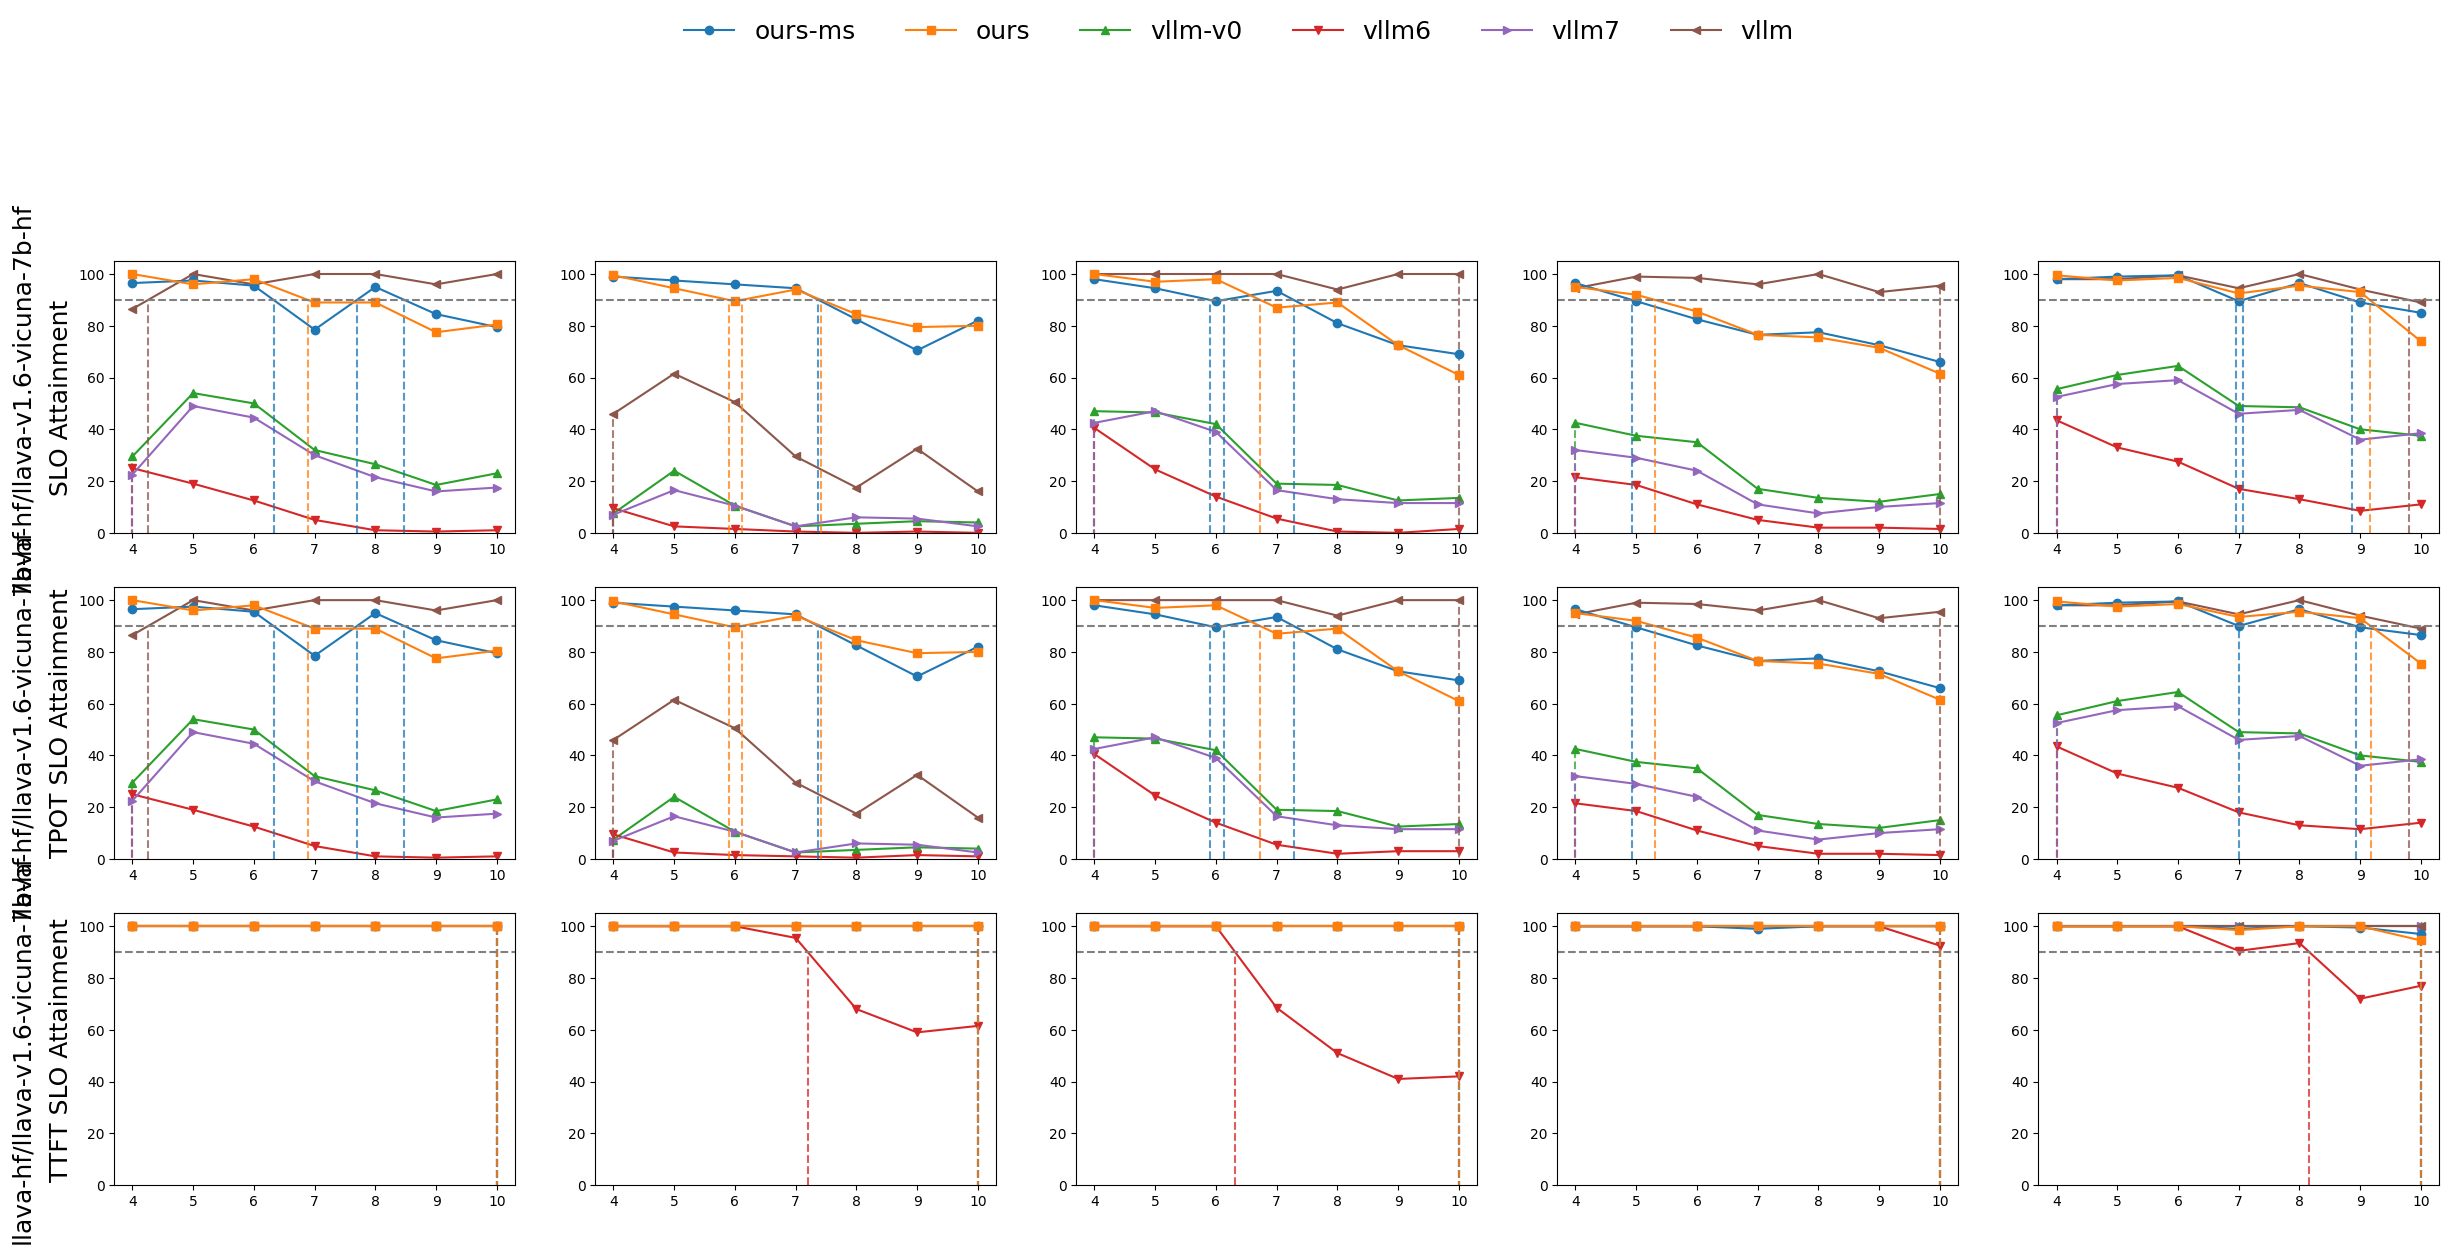

In [92]:
# visualize selected line
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter

def get_intersection_points(x, y, target_y) -> list[tuple[float, float]]:
    cross_points = []

    # Check if y_i is close to target_y
    for xi, yi in zip(x, y):
        if np.isclose(yi, target_y):
            cross_points.append((xi, yi))

    # Check if each line crosses the y=target_y line
    for i in range(len(x) - 1):
        x0, x1 = x[i], x[i + 1]
        y0, y1 = y[i], y[i + 1]
        if (y0 - target_y) * (y1 - target_y) < 0:
            t = (target_y - y0) / (y1 - y0)
            x_inter = x0 + t * (x1 - x0)
            y_inter = y0 + t * (y1 - y0)
            cross_points.append((x_inter, y_inter))

    return cross_points

def draw_slo_vertical_line(x_values, y_values, slo_target, ax, **kwargs):
    cross_points = get_intersection_points(x_values, y_values, slo_target)
    if not cross_points:
        if y_values[0] < slo_target:
            ax.plot([x_values[0], x_values[0]], [-5, y_values[0]], **kwargs)
        elif y_values[-1] > slo_target:
            ax.plot([x_values[-1], x_values[-1]], [-5, y_values[-1]], **kwargs)
    for x, y in cross_points:
        ax.plot([x, x], [0, y], **kwargs)

n_rows = n_models * 3
n_cols = n_datasets
model_id = {model: i for i, model in enumerate(models)}
id_model = {i: model for i, model in enumerate(models)}
dataset_id = {dataset: i for i, dataset in enumerate(datasets)}
id_dataset = {i: dataset for i, dataset in enumerate(datasets)}
method_id = {method: i for i, method in enumerate(methods)}
id_method = {i: method for i, method in enumerate(methods)}
marker_list = ['o', 's', '^', 'v', '>', '<', 'd', 'p', '*', 'h', 'H', 'x', '+', '.', ',', '|', '_']
color_list = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
print(f'model_id: {model_id}')
print(f'dataset_id: {dataset_id}')
print(f'method_id: {method_id}')
figsize=(6 * n_cols, 4 * n_rows)

fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
axes = np.atleast_2d(axes) # to avoid plt.subplots returns an array that is not two dimension when n_rows or n_cols is not greater than one
for line_data in selected_line_data:
    row_id = model_id[line_data.model]
    col_id = dataset_id[line_data.dataset]
    i = method_id[line_data.method]
    color = color_list[i]
    marker = marker_list[i]
    
    for k in range(3):
        ax = axes[row_id + k][col_id]
        x = line_data.request_rates
        if k == 0:
            y = line_data.slo_attainment
        elif k == 1:
            y = line_data.tpot_slo_attainment
        elif k == 2:
            y = line_data.ttft_slo_attainment
        ax.plot(x, y, color=color, marker=marker)
        draw_slo_vertical_line(x, y, slo_target=0.9, ax=ax, color=color, linestyle='--', alpha=0.75)
    
for i in range(n_models):
    for j in range(n_datasets):
        for k in range(3):
            ax = axes[i + k][j]
            ax.set_ylim(0, 1.05)
            
            formatter = FuncFormatter(lambda val, pos: f'{val * 100:.0f}')
            ax.yaxis.set_major_formatter(formatter)
            ax.axhline(y=0.9, color="gray", linestyle="--")
            
            if j == 0: 
                if k == 0:
                    ax.set_ylabel('SLO Attainment', fontsize=18)
                elif k == 1:
                    ax.set_ylabel('TPOT SLO Attainment', fontsize=18)
                elif k == 2:
                    ax.set_ylabel('TTFT SLO Attainment', fontsize=18)
                    
                ax.text(-0.2, 0.5, id_model[i], transform=ax.transAxes, ha='right', va='center', rotation=90, fontsize=18)
            if i == n_rows - 1:
                axes[i][j].set_xlabel('Request Rate (req/s)', fontsize=18)
                ax.text(7, -0.3, id_dataset[j], ha='center', va='bottom', fontsize=18)
            
fig.legend(
    [Line2D([0], [0], color=color_list[i], marker=marker_list[i]) for i in range(len(method_id))],
    [method for method, id in method_id.items()], 
    loc='upper center', ncol=len(method_id), fontsize=18, frameon=False, bbox_to_anchor=(0.5, 1.1))

In [64]:
os.makedirs(figures_dir, exist_ok=True)
fig.savefig(os.path.join(figures_dir, "slo_attainment.pdf"), bbox_inches="tight")

In [94]:
for line_data in selected_line_data:
    print(line_data.method, line_data.dataset, line_data.avg_tpot)

vllm-v0 vizwiz_vqa [0.037586273324269885, 0.024133671855719546, 0.028086115972700505, 0.049052406798001144, 0.06419235676368357, 0.06615354488955857, 0.0632831760961141]
vllm6 vizwiz_vqa [0.03540209875138069, 0.06483993750507801, 0.08484346038374964, 0.09277589664666225, 0.09546418240479124, 0.09693584594395939, 0.09491752918455634]
vllm7 vizwiz_vqa [0.04087813185451906, 0.026717312092010836, 0.030413720027730382, 0.054635189554420996, 0.06771142070735534, 0.06802334661391041, 0.06644064173324386]
vllm vizwiz_vqa [0.02768460414784132, 0.022395615532649685, 0.0248187506591943, 0.03682600696290281, 0.04555300008137578, 0.048792676603087067, 0.05431658172400062]
ours-ms vizwiz_vqa [0.02231741374765067, 0.027165907210250775, 0.029053433801007156, 0.0396063513323443, 0.04269013403173506, 0.04314414028766997, 0.04257512386928738]
ours vizwiz_vqa [0.022020355114392997, 0.02794829420318607, 0.03121357302547004, 0.04127618513473013, 0.04404104930184294, 0.0454001211238266, 0.044027878098441255]